In [111]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [112]:
os.environ["CUDA_VISIBLE_DEVICES"] = '012'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

In [113]:
# Setting up training and testing data:
mean_1 = [0, 0, 0, 0, 0]
cov_1 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_2 = [1, 1, 1, 1, 1]
cov_2 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

mean_3 = [-1, -1, -1, -1, -1]
cov_3 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]


x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
y_1 = np.random.multivariate_normal(mean_1, cov_1, size=100000)

x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
y_2 = np.random.multivariate_normal(mean_2, cov_2, size=100000)

x_3 = np.random.multivariate_normal(mean_3, cov_3, size=1000000)
y_3 = np.random.multivariate_normal(mean_3, cov_3, size=100000)


In [114]:
print(x_1[0])

[-0.59204797  0.67870432  0.38378122 -0.35968295 -1.41326552]


Distribution of the raw samples

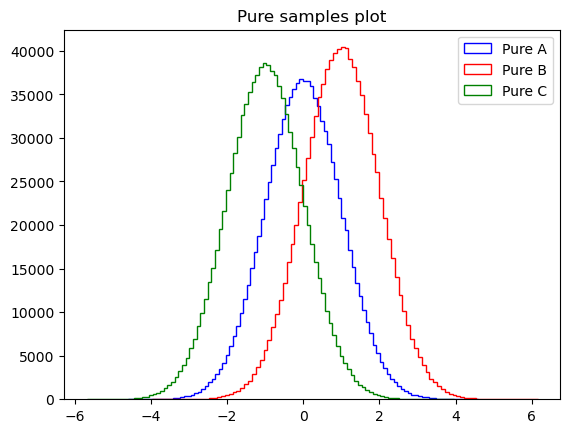

In [115]:
plt.hist(x_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step', label = 'Pure A')
plt.hist(x_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step', label = 'Pure B')
plt.hist(x_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step', label = 'Pure C')
plt.title("Pure samples plot")
plt.legend()
plt.show()

In [193]:
# Preparing three samples
n_samples = 3
n_1_1 = 80000 #Number of signal samples in dominant class
n_1_2 = 10000
n_1_3 = 10000

n_2_1 = 75000
n_2_2 = 15000
n_2_3 = 10000

n_3_1 = 55000
n_3_2 = 20000
n_3_3 = 25000

sample_1_1_train = x_1[0:n_1_1]
#Using one-hot encoding here
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_1_1_train)[0]).reshape(np.shape(sample_1_1_train)[0],n_samples)

sample_1_2_train = x_2[0:n_1_2]
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_1_2_train)[0]).reshape(np.shape(sample_1_2_train)[0],n_samples)
sample_1_3_train = x_3[0:n_1_3]
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_1_3_train)[0]).reshape(np.shape(sample_1_3_train)[0],n_samples)

sample_2_1_train = x_1[n_1_1:n_1_1+n_2_1]
#Using one-hot encoding here
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_2_1_train)[0]).reshape(np.shape(sample_2_1_train)[0],n_samples)

sample_2_2_train = x_2[n_1_2:n_1_2 + n_2_2]
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_2_2_train)[0]).reshape(np.shape(sample_2_2_train)[0],n_samples)
sample_2_3_train = x_3[n_1_3:n_1_3+n_2_3]
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_2_3_train)[0]).reshape(np.shape(sample_2_3_train)[0],n_samples)

sample_3_1_train = x_1[n_1_1+n_2_1:n_1_1+n_2_1+n_3_1]
#Using one-hot encoding here
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                      np.shape(sample_3_1_train)[0]).reshape(np.shape(sample_3_1_train)[0],n_samples)

sample_3_2_train = x_2[n_1_2+n_2_2:n_1_2+n_2_2+n_3_2]
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                      np.shape(sample_3_2_train)[0]).reshape(np.shape(sample_3_2_train)[0],n_samples)
sample_3_3_train = x_3[n_1_3+n_2_3:n_1_3+n_2_3+n_3_3]
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                      np.shape(sample_3_3_train)[0]).reshape(np.shape(sample_3_3_train)[0],n_samples)






In [194]:
x_test = np.concatenate((y_1, y_2, y_3))
y_test_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(y_1)[0]).reshape(np.shape(y_1)[0],n_samples)
y_test_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(y_2)[0]).reshape(np.shape(y_2)[0],n_samples)
y_test_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(y_3)[0]).reshape(np.shape(y_3)[0],n_samples)
y_test = np.concatenate((y_test_1, y_test_2, y_test_3))

In [184]:
#y_test = np.argmax(y_test, axis = 1)

In [195]:
print(y_test)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


One versus all

In [196]:
rng = np.random.default_rng()
x_train_1 = np.concatenate((sample_1_1_train, sample_1_2_train, sample_1_3_train))
y_train_1 = np.tile(np.array([1., 0., 0.]), 
            np.shape(x_train_1)[0]).reshape(np.shape(x_train_1)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                               true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_train_1)[0])

x_shuffle_1 = x_train_1[indices_1]
y_shuffle_1 = y_train_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_train_2 = np.concatenate((sample_2_1_train, sample_2_2_train, sample_2_3_train))
y_train_2 = np.tile(np.array([0., 1., 0.]), 
            np.shape(x_train_2)[0]).reshape(np.shape(x_train_2)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                               true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_train_2)[0])

x_shuffle_2 = x_train_2[indices_2]
y_shuffle_2 = y_train_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_train_3 = np.concatenate((sample_3_1_train, sample_3_2_train, sample_3_3_train))
y_train_3 = np.tile(np.array([0., 0., 1.]), 
            np.shape(x_train_3)[0]).reshape(np.shape(x_train_3)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                               true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_train_3)[0])

x_shuffle_3 = x_train_3[indices_3]
y_shuffle_3 = y_train_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]


Distribution of the mixed samples

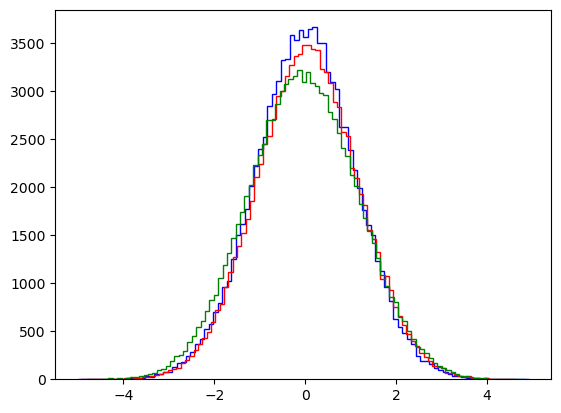

In [197]:
plt.hist(x_train_1[:,0], bins = 100, edgecolor = 'b', histtype = 'step', label = 'Mixed A')
plt.hist(x_train_2[:,0], bins = 100, edgecolor = 'r', histtype = 'step', label = 'Mixed B')
plt.hist(x_train_3[:,0], bins = 100, edgecolor = 'g', histtype = 'step', label = 'Mixed C')
plt.show()

Code from Feng-Yang:

In [198]:
def build_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [199]:
x_train = np.concatenate((x_shuffle_1, x_shuffle_2, x_shuffle_3))
y_train = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label_train = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

#y_train = np.argmax(y_train, axis = 1)
#true_label_train = np.argmax(true_label_train, axis = 1)

indices_train = rng.permutation(np.shape(x_train)[0])

x_train = x_train[indices_train]
y_train = y_train[indices_train]
true_label_train = true_label_train[indices_train]


In [200]:
print(y_train)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


Train on 240000 samples, validate on 60000 samples
Epoch 1/10
240000/240000 [==============================] - 1s 6us/sample - loss: 1.0861 - accuracy: 0.3827 - val_loss: 1.0855 - val_accuracy: 0.3839
Epoch 2/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0848 - accuracy: 0.3862 - val_loss: 1.0848 - val_accuracy: 0.3867
Epoch 3/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0848 - accuracy: 0.3859 - val_loss: 1.0858 - val_accuracy: 0.3871
Epoch 4/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0847 - accuracy: 0.3857 - val_loss: 1.0852 - val_accuracy: 0.3847
Epoch 5/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0844 - accuracy: 0.3867 - val_loss: 1.0847 - val_accuracy: 0.3864
Epoch 6/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0844 - accuracy: 0.3864 - val_loss: 1.0844 - val_accuracy: 0.3884
Epoch 7/10
240000/240000 [=======================

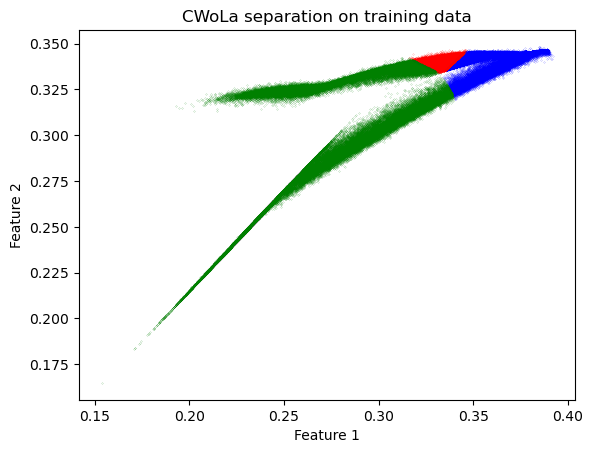

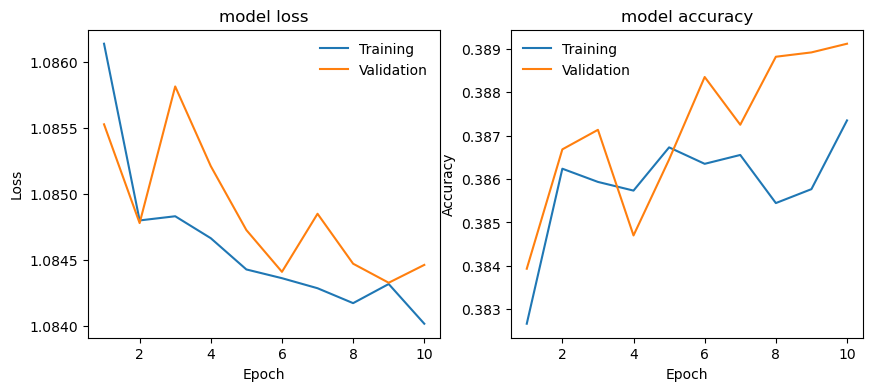

Train on 240000 samples, validate on 60000 samples
Epoch 1/10
240000/240000 [==============================] - 1s 5us/sample - loss: 1.0860 - accuracy: 0.9893 - val_loss: 1.0860 - val_accuracy: 0.9958
Epoch 2/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9969 - val_loss: 1.0860 - val_accuracy: 0.9980
Epoch 3/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9983 - val_loss: 1.0860 - val_accuracy: 0.9989
Epoch 4/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9990 - val_loss: 1.0860 - val_accuracy: 0.9994
Epoch 5/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9994 - val_loss: 1.0860 - val_accuracy: 0.9996
Epoch 6/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9996 - val_loss: 1.0860 - val_accuracy: 0.9997
Epoch 7/10
240000/240000 [=======================

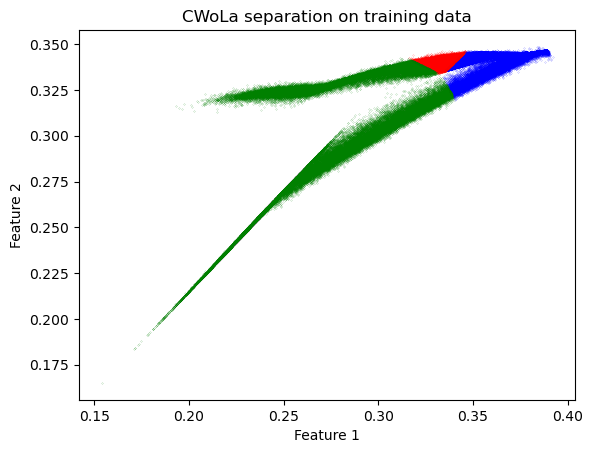

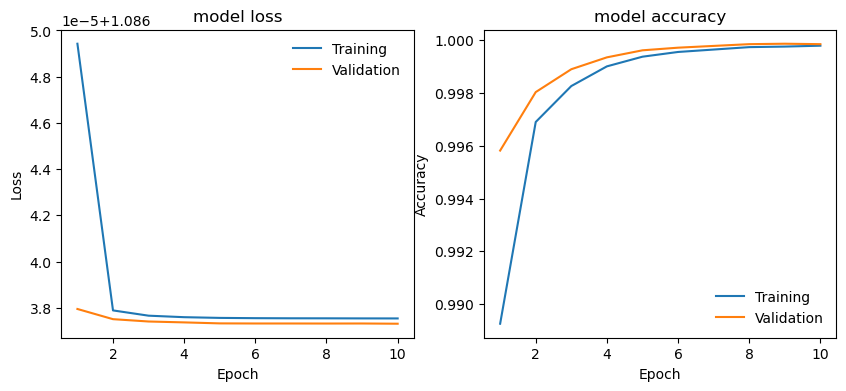

Train on 240000 samples, validate on 60000 samples
Epoch 1/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 2/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 3/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 4/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 5/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 6/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 7/10
240000/240000 [=======================

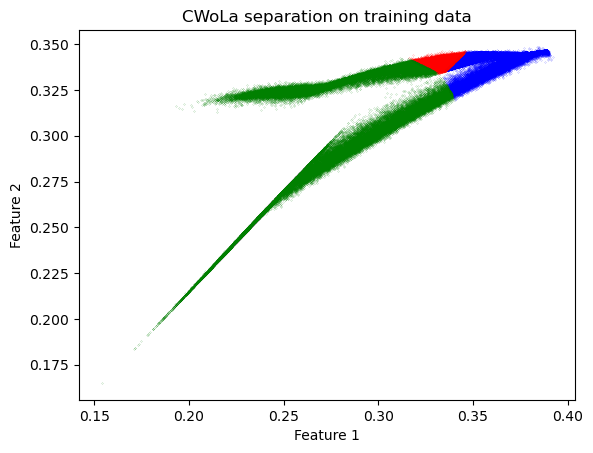

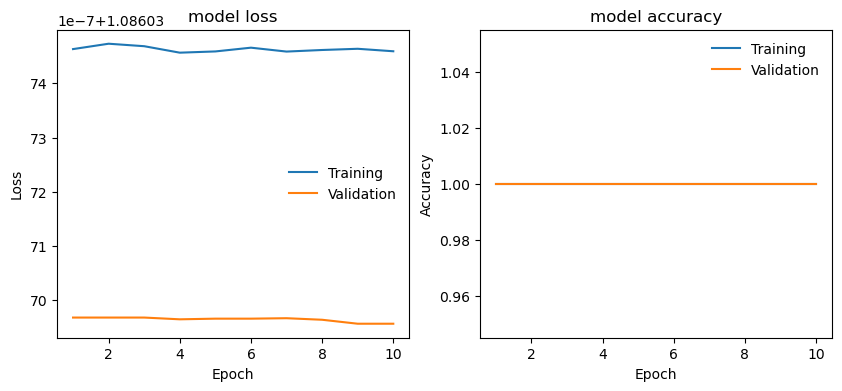

Train on 240000 samples, validate on 60000 samples
Epoch 1/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 2/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 3/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 4/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 5/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 6/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 7/10
240000/240000 [=======================

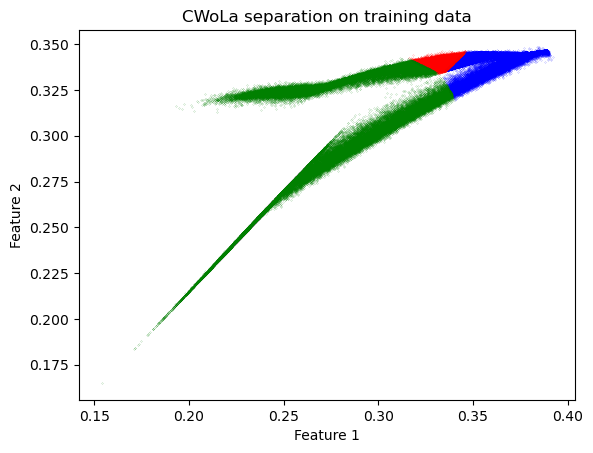

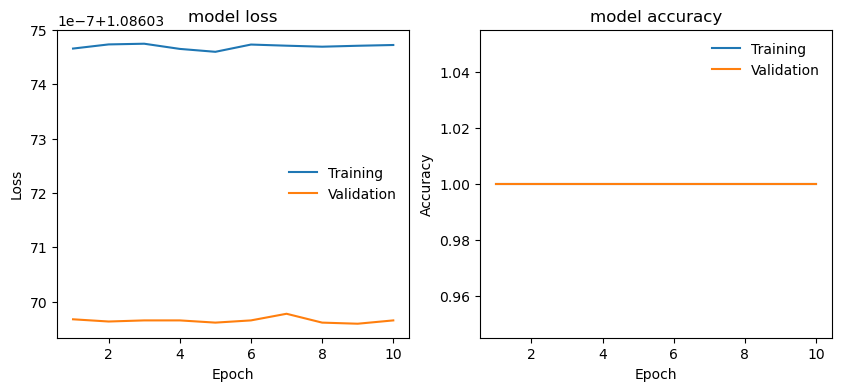

Train on 240000 samples, validate on 60000 samples
Epoch 1/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 2/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 3/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 4/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 1.0000 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 5/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9991 - val_loss: 1.0860 - val_accuracy: 1.0000
Epoch 6/10
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0860 - accuracy: 0.9986 - val_loss: 1.0860 - val_accuracy: 0.9998
Epoch 7/10
240000/240000 [=======================

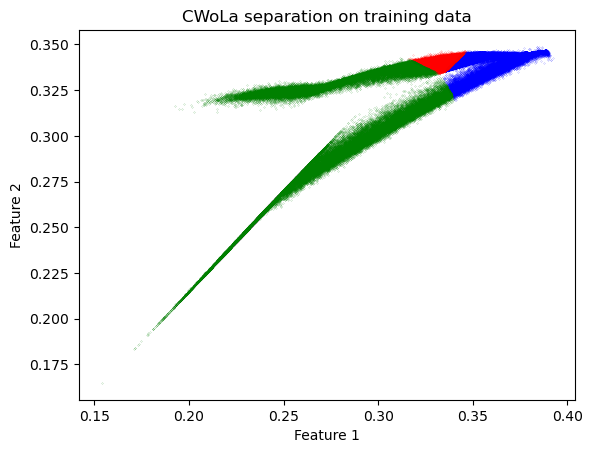

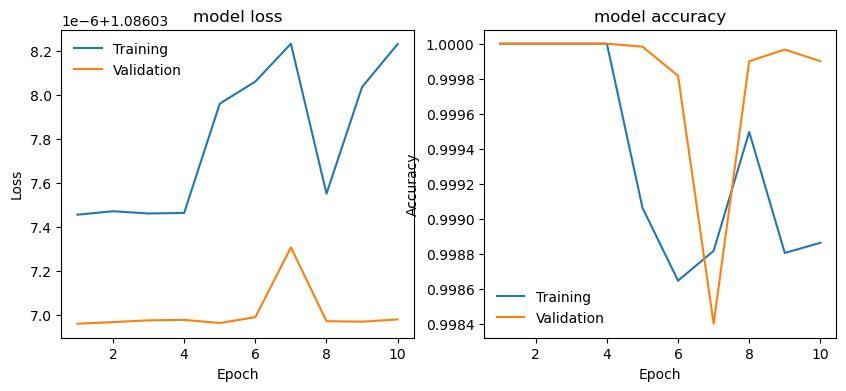

In [207]:
model = build_model(x_train.shape[1])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
y_train_1 = y_train
for i in range(5):
    history = model.fit(x_train, y_train_1, validation_split = 0.2, epochs=10, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])
    predict = model.predict(x_train)
    '''
    predict[np.argmax(predict, axis = 1) == 0] = [1., 0., 0.]
    predict[np.argmax(predict, axis = 1) == 1] = [0., 1., 0.]
    predict[np.argmax(predict, axis = 1) == 2] = [0., 0., 1.]
    '''
    y_train_1 = predict
    predict_0 = predict[np.argmax(y_train_1, axis = 1) == 0]
    predict_1 = predict[np.argmax(y_train_1, axis = 1) == 1]
    predict_2 = predict[np.argmax(y_train_1, axis = 1) == 2]
    plt.scatter(predict_0[:,0], predict_0[:,1], c = 'b', s = 0.01, label = 'Mixed Sample A')
    plt.scatter(predict_1[:,0], predict_1[:,1], c = 'r', s = 0.01, label = 'Mixed Sample B')
    plt.scatter(predict_2[:,0], predict_2[:,1], c = 'g', s = 0.01, label = 'Mixed Sample C')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('CWoLa separation on training data')
    plt.show()
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history.history['loss']) + 1)

    ax[0].plot(x, history.history['loss'], label='Training')
    ax[0].plot(x, history.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history.history['accuracy'], label='Training')
    ax[1].plot(x, history.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()

In [208]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 57.65%


In [153]:
loss, accuracy = model.evaluate(x_train[-100000:], y_train[-100000:], verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 38.94%


In [209]:
x_predict = model.predict(x_test)

In [204]:
y_predict = model.predict(x_train[-100000:])

In [156]:
print(x_predict)

[[0.34704685 0.35626316 0.29668993]
 [0.36982334 0.35647604 0.27370065]
 [0.36157286 0.35740408 0.2810231 ]
 ...
 [0.33169496 0.3170327  0.3512723 ]
 [0.2669186  0.24788627 0.48519516]
 [0.23105401 0.22120851 0.5477375 ]]


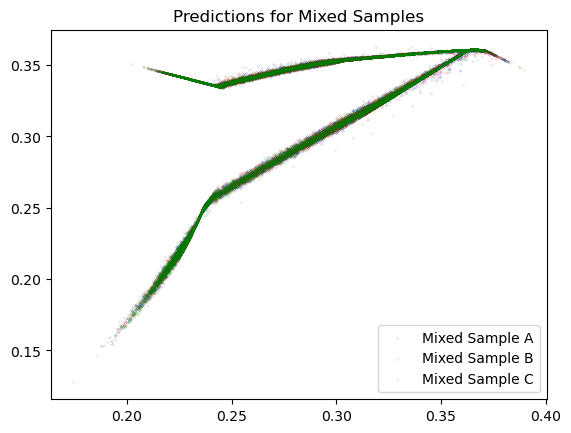

In [205]:
x_predict_0 = y_predict[np.argmax(y_train[-100000:], axis = 1) == 0]
x_predict_1 = y_predict[np.argmax(y_train[-100000:], axis = 1) == 1]
x_predict_2 = y_predict[np.argmax(y_train[-100000:], axis = 1) == 2]
plt.scatter(x_predict_0[:,0], x_predict_0[:,1], c = 'b', s = 0.01, label = "Mixed Sample A")
plt.scatter(x_predict_1[:,0], x_predict_1[:,1], c = 'r', s = 0.01, label = "Mixed Sample B")
plt.scatter(x_predict_2[:,0], x_predict_2[:,1], c = 'g', s = 0.01, label = "Mixed Sample C")
plt.title("Predictions for Mixed Samples")
plt.legend()
plt.show()

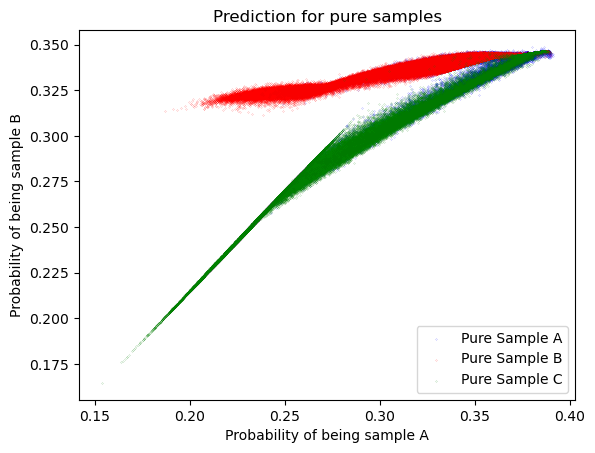

In [210]:
x_predict_0 = x_predict[np.argmax(y_test, axis = 1) == 0]
x_predict_1 = x_predict[np.argmax(y_test, axis = 1) == 1]
x_predict_2 = x_predict[np.argmax(y_test, axis = 1) == 2]
plt.scatter(x_predict_0[:,0], x_predict_0[:,1], c = 'b', s = 0.01,label = "Pure Sample A")
plt.scatter(x_predict_1[:,0], x_predict_1[:,1], c = 'r', s = 0.01,label = "Pure Sample B")
plt.scatter(x_predict_2[:,0], x_predict_2[:,1], c = 'g', s = 0.01,label = "Pure Sample C")
plt.xlabel('Probability of being sample A')
plt.ylabel('Probability of being sample B')
plt.legend()
plt.title("Prediction for pure samples")
plt.show()

In [50]:
print(np.shape(np.argmax(x_predict_0, axis = 1)[np.argmax(x_predict_0, axis = 1) == 0]))
print(np.shape(np.argmax(x_predict_1, axis = 1)[np.argmax(x_predict_1, axis = 1) == 1]))
print(np.shape(np.argmax(x_predict_2, axis = 1)[np.argmax(x_predict_2, axis = 1) == 2]))


(14823,)
(18871,)
(18874,)


In [162]:
loss, accuracy = model.evaluate(y_3, y_test_3, verbose=0)
print(f"One-vs-All Test Accuracy: {accuracy * 100:.2f}%")

One-vs-All Test Accuracy: 81.57%


In [301]:
print(np.argmax(x_predict_0, axis = 1) == 1)

[False False False ... False False False]


In [50]:
print(np.mean(x_predict_0), np.mean(x_predict_1), np.mean(x_predict_2))

0.33333337 0.33333337 0.33333334


One versus Rest strategy

In [163]:
def build_model_ovr(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 0.6331 - accuracy: 0.6652 - val_loss: 0.6328 - val_accuracy: 0.6646
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6310 - accuracy: 0.6672 - val_loss: 0.6326 - val_accuracy: 0.6646
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6309 - accuracy: 0.6672 - val_loss: 0.6325 - val_accuracy: 0.6646
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6308 - accuracy: 0.6672 - val_loss: 0.6325 - val_accuracy: 0.6646
Epoch 5/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6306 - accuracy: 0.6672 - val_loss: 0.6328 - val_accuracy: 0.6646
Epoch 6/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6308 - accuracy: 0.6672 - val_loss: 0.6327 - val_accuracy: 0.6646
Epoch 7/50
240000/240000 [=======================

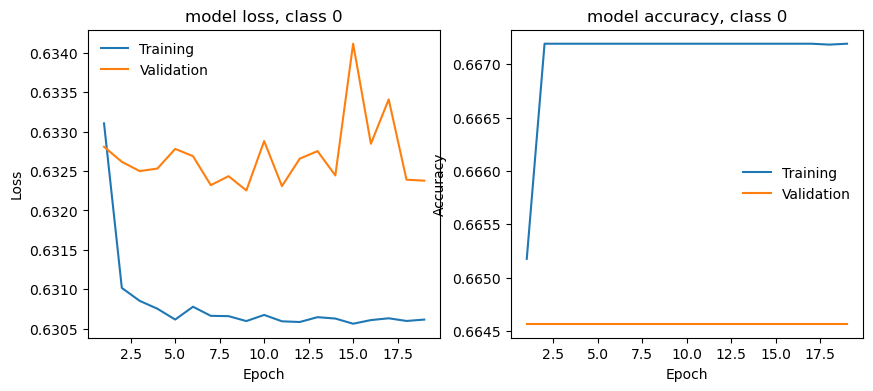

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 2s 7us/sample - loss: 0.6360 - accuracy: 0.6652 - val_loss: 0.6334 - val_accuracy: 0.6679
Epoch 2/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6345 - accuracy: 0.6664 - val_loss: 0.6325 - val_accuracy: 0.6679
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 0.6342 - accuracy: 0.6664 - val_loss: 0.6328 - val_accuracy: 0.6679
Epoch 4/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6343 - accuracy: 0.6664 - val_loss: 0.6325 - val_accuracy: 0.6679
Epoch 5/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6341 - accuracy: 0.6664 - val_loss: 0.6325 - val_accuracy: 0.6679
Epoch 6/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6341 - accuracy: 0.6664 - val_loss: 0.6327 - val_accuracy: 0.6679
Epoch 7/50
240000/240000 [=======================

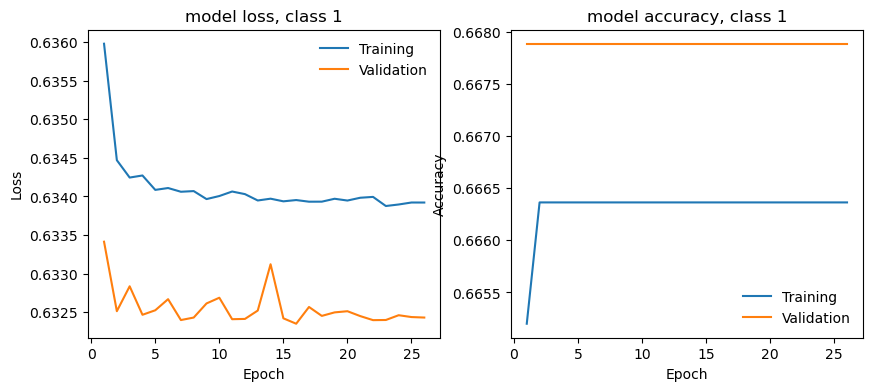

Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 0.6266 - accuracy: 0.6687 - val_loss: 0.6225 - val_accuracy: 0.6719
Epoch 2/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6236 - accuracy: 0.6712 - val_loss: 0.6223 - val_accuracy: 0.6711
Epoch 3/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6235 - accuracy: 0.6711 - val_loss: 0.6215 - val_accuracy: 0.6720
Epoch 4/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6235 - accuracy: 0.6713 - val_loss: 0.6223 - val_accuracy: 0.6722
Epoch 5/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6235 - accuracy: 0.6710 - val_loss: 0.6219 - val_accuracy: 0.6719
Epoch 6/50
240000/240000 [==============================] - 1s 5us/sample - loss: 0.6232 - accuracy: 0.6712 - val_loss: 0.6218 - val_accuracy: 0.6711
Epoch 7/50
240000/240000 [=======================

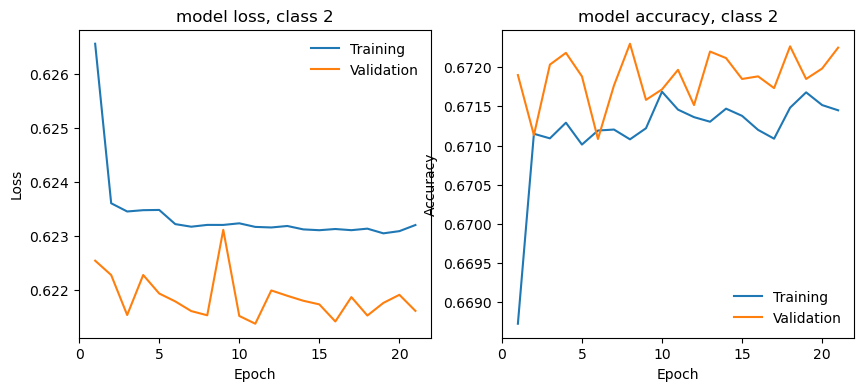

In [164]:
models = []
for class_index in range(n_samples):
    y_train_bin = np.where(np.argmax(y_train, axis = 1) == class_index, 1, 0)
    model_2 = build_model_ovr(x_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
    history_2 = model_2.fit(x_train, y_train_bin, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                    callbacks=[
                              early_stopping,
                               ])

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history_2.history['loss']) + 1)

    ax[0].plot(x, history_2.history['loss'], label='Training')
    ax[0].plot(x, history_2.history['val_loss'], label='Validation')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss, class {class_index}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history_2.history['accuracy'], label='Training')
    ax[1].plot(x, history_2.history['val_accuracy'], label='Validation')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy, class {class_index}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()
    
    models.append(model_2)

In [165]:
# Making predictions using the OvR strategy
def predict_ovr(models, X_test):
    predictions = np.zeros((X_test.shape[0], len(models)))
    
    # Predict using each model
    for idx, model in enumerate(models):
        pred = model.predict(X_test)
        predictions[:, idx] = pred.flatten()
    
    # The final class is the one with the highest confidence score
    return np.argmax(predictions, axis=1), predictions

# Get final predictions
final_predictions, predictions = predict_ovr(models, x_test)

# Calculate accuracy
accuracy = np.mean(final_predictions == np.argmax(y_test, axis = 1))
print(f"One-vs-Rest Test Accuracy: {accuracy * 100:.2f}%")
print(final_predictions)

One-vs-Rest Test Accuracy: 57.70%
[0 0 0 ... 2 2 2]


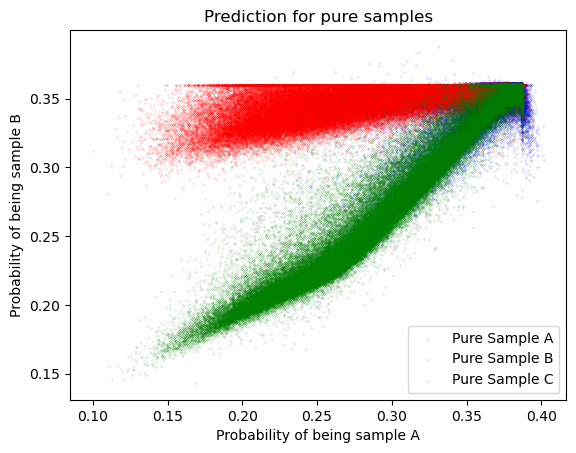

In [166]:
y_predict_0 = predictions[np.argmax(y_test, axis = 1) == 0]
y_predict_1 = predictions[np.argmax(y_test, axis = 1) == 1]
y_predict_2 = predictions[np.argmax(y_test, axis = 1) == 2]
plt.scatter(y_predict_0[:,0], y_predict_0[:,1], c = 'b', s = 0.01,label = "Pure Sample A")
plt.scatter(y_predict_1[:,0], y_predict_1[:,1], c = 'r', s = 0.01,label = "Pure Sample B")
plt.scatter(y_predict_2[:,0], y_predict_2[:,1], c = 'g', s = 0.01,label = "Pure Sample C")
plt.xlabel('Probability of being sample A')
plt.ylabel('Probability of being sample B')
plt.legend()
plt.title("Prediction for pure samples")
plt.show()
plt.show()